In [1]:
## Imports
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
## Load data
all = pd.read_pickle("../climate_classifier/scored_data/ft_meetings_all_2.3.pkl")

all["year"] = all["date"].astype("str").str[:4]
all["month"] = all["date"].astype("str").str[5:7]
all["politician"] = all["politician"].str.strip()
all["id"] = all["date"]
all["id"] = all["id"].astype("category")
all["id"] = all["id"].cat.codes
all.head(2)

,speaker,politician,title,party,text,date,y_pred,year,month,id
0,Statsministeren Helle Thorning-Schmidt,Helle Thorning-Schmidt,Statsministeren,(S),(Talen er under udarbejdelse) (Talen er under ...,2012-10-02,non-climate,2012,10,0
1,Statsministeren Helle Thorning-Schmidt,Helle Thorning-Schmidt,Statsministeren,(S),"000 døgninstitutioner, opholdssteder og plejef...",2012-10-02,non-climate,2012,10,0


In [3]:
print(len(all))
all = all.drop_duplicates(subset="text")
print(len(all))

335170
332094


In [4]:
climate = all[all["y_pred"]=="climate"]
print(len(all))
print(len(climate))

332094
16986


### General stats

In [5]:
all.groupby("y_pred").count()

,speaker,politician,title,party,text,date,year,month,id
y_pred,,,,,,,,,
climate,16986,16986,16986,16986,16986,16986,16986,16986,16986
non-climate,315108,315108,315108,315108,315108,315108,315108,315108,315108


In [6]:
all[all["y_pred"]=="climate"].nunique()

speaker         579
politician      325
title            43
party            19
text          16986
date            687
y_pred            1
year             11
month            10
id              687
dtype: int64

,text,Cumulative Sum,No. of quotes
count,406.000000,406.000000,406.000000
mean,817.965517,74426.455665,817.965517
std,884.428039,86961.661438,884.428039
min,1.000000,1.000000,1.000000
25%,144.250000,4795.750000,144.250000
50%,492.000000,36602.500000,492.000000
75%,1238.000000,119705.000000,1238.000000
max,5037.000000,332094.000000,5037.000000


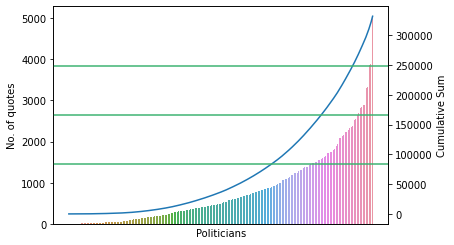

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
pol_count = all.groupby("politician")["text"].count().reset_index().sort_values(by="text")
pol_count["Cumulative Sum"] = pol_count["text"].cumsum()
pol_count["No. of quotes"] = pol_count["text"]
pol_count["Politicians"] = pol_count["politician"]

g = sns.barplot(data=pol_count, x="Politicians", y="No. of quotes")
ax2 = plt.twinx()
sns.lineplot(data=pol_count, x="Politicians", y="Cumulative Sum",ax=ax2)
g.set_xticks(ticks=[])
plt.axhline(max(pol_count["Cumulative Sum"])/4, color='mediumseagreen')
plt.axhline(max(pol_count["Cumulative Sum"])/2, color='mediumseagreen')
plt.axhline((max(pol_count["Cumulative Sum"])/4)*3, color='mediumseagreen')
plt.savefig('ft-meetings-quotes.pdf')
pol_count.describe()

In [13]:
print(len(pol_count))
print(len(pol_count[pol_count["Cumulative Sum"]>= max(pol_count["Cumulative Sum"])/2]))
print(69/406)
pol_count[-10:]

406
69
0.16995073891625614


,politician,text,Cumulative Sum,No. of quotes,Politicians
36,Bent Bøgsted,2974,296811,2974,Bent Bøgsted
275,Morten Bødskov,3299,300110,3299,Morten Bødskov
181,Karsten Lauritzen,3317,303427,3317,Karsten Lauritzen
254,Mattias Tesfaye,3488,306915,3488,Mattias Tesfaye
208,Lars Løkke Rasmussen,3583,310498,3583,Lars Løkke Rasmussen
262,Mette Frederiksen,3857,314355,3857,Mette Frederiksen
217,Lisbeth Bech Poulsen,3879,318234,3879,Lisbeth Bech Poulsen
63,Christian Juhl,4279,322513,4279,Christian Juhl
95,Finn Sørensen,4544,327057,4544,Finn Sørensen
290,Ole Birk Olesen,5037,332094,5037,Ole Birk Olesen


,text,Cumulative Sum,No. of climate-related quotes
count,325.000000,325.000000,325.000000
mean,52.264615,2461.033846,52.264615
std,99.023586,3491.400773,99.023586
min,1.000000,1.000000,1.000000
25%,5.000000,186.000000,5.000000
50%,15.000000,913.000000,15.000000
75%,54.000000,3199.000000,54.000000
max,812.000000,16986.000000,812.000000


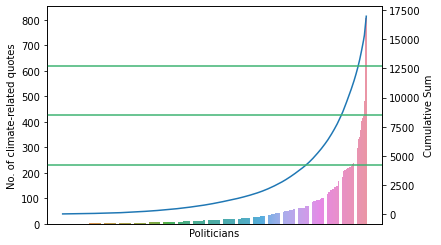

In [14]:
import seaborn as sns
pol_count = all[all["y_pred"]=="climate"].groupby("politician")["text"].count().reset_index().sort_values(by="text")
pol_count["Cumulative Sum"] = pol_count["text"].cumsum()
pol_count["No. of climate-related quotes"] = pol_count["text"]
pol_count["Politicians"] = pol_count["politician"]

g = sns.barplot(data=pol_count, x="Politicians", y="No. of climate-related quotes")
ax2 = plt.twinx()
sns.lineplot(data=pol_count, x="Politicians", y="Cumulative Sum",ax=ax2)
g.set_xticks(ticks=[])
plt.axhline(max(pol_count["Cumulative Sum"])/4, color='mediumseagreen')
plt.axhline(max(pol_count["Cumulative Sum"])/2, color='mediumseagreen')
plt.axhline((max(pol_count["Cumulative Sum"])/4)*3, color='mediumseagreen')
plt.savefig('ft-meetings-climate-quotes.pdf')
pol_count.describe()

In [10]:
print(len(pol_count))
print(len(pol_count[pol_count["Cumulative Sum"]>= max(pol_count["Cumulative Sum"])/2]))
print(27/325)
pol_count

325
27
0.08307692307692308


,politician,text,Cumulative Sum,No. of climate-related quotes,Politicians
136,Jørgen Arbo-Bæhr,1,1,1,Jørgen Arbo-Bæhr
268,Rasmus Stoklund,1,2,1,Rasmus Stoklund
306,Tina Nedergaard,1,3,1,Tina Nedergaard
32,Birgitte Josefsen,1,4,1,Birgitte Josefsen
286,Sisse Marie Welling,1,5,1,Sisse Marie Welling
...,...,...,...,...,...
52,Christian Poll,416,14462,416,Christian Poll
117,Jens Joel,424,14886,424,Jens Joel
59,Dan Jørgensen,480,15366,480,Dan Jørgensen
172,Lars Christian Lilleholt,808,16174,808,Lars Christian Lilleholt


In [11]:
#Raw view 
climate.groupby(['title']).count().sort_values(by='text', ascending=False)['text'].head(20)

title
Member                                               13502
Energi-, forsynings- og klimaministeren                698
Klima-, energi- og forsyningsministeren                469
Statsministeren                                        421
Skatteministeren                                       332
Klima-, energi- og bygningsministeren                  299
Miljøministeren                                        202
Finansministeren                                       190
Transportministeren                                    158
Miljø- og fødevareministeren                           117
Udenrigsministeren                                     111
Ministeren for fødevarer, landbrug og fiskeri           77
Erhvervsministeren                                      59
Transport-, bygnings- og boligministeren                52
Morten Bødskov                                          32
Ministeren for fødevarer, fiskeri og ligestilling       31
Handels- og udviklingsministeren                  

### Temporal Analysis

In [5]:
parties_selection = ["(S)", "(V)", "(SF)", "(KF)", "(DF)", "(EL)"
                    ,"(RV)", "(ALT)", "(LA)"]
print(len(all))
df_selection = all[all["party"].isin(parties_selection)]
df_selection
print(len(df_selection))

332094
318485


In [6]:
df_selection['climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="climate" else 0)
df_selection['non-climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="non-climate" else 0)
df_selection.head(1)

C:\Users\COBOD\AppData\Local\Temp\ipykernel_13320\990915804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="climate" else 0)
C:\Users\COBOD\AppData\Local\Temp\ipykernel_13320\990915804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['non-climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="non-climate" else 0)


,speaker,politician,title,party,text,date,y_pred,year,month,id,climate,non-climate
0,Statsministeren Helle Thorning-Schmidt,Helle Thorning-Schmidt,Statsministeren,(S),(Talen er under udarbejdelse) (Talen er under ...,2012-10-02,non-climate,2012,10,0,0,1


##### Climate proportion

In [7]:

quarterly = df_selection.groupby(df_selection['date'].dt.to_period('Q')).agg({'climate': 'sum', 'non-climate':'sum'})
quarterly['percentage_climate'] = quarterly.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)

view = pd.DataFrame(quarterly.drop(columns=['climate', 'non-climate']))

In [8]:
## Drop Q3
view["date2"] = view.index.astype(str)
viewQ = view[(view["date2"].str.endswith("Q1"))|(view["date2"].str.endswith("Q2"))|(view["date2"].str.endswith("Q4"))]

In [9]:
yearly = df_selection.groupby(df_selection['date'].dt.to_period('Y')).agg({'climate': 'sum', 'non-climate':'sum'})
yearly['percentage_climate'] = yearly.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)

view2 = yearly.drop(columns=['climate', 'non-climate'])

## Comment out to get from 2012 ->
view2["date2"] = view2.index.astype(str)
view2.head(1)

,percentage_climate,date2
date,,
2012,2.138466,2012


C:\Users\COBOD\AppData\Local\Temp\ipykernel_13320\418275884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewQ["Quarters"] = viewQ["date2"]
C:\Users\COBOD\AppData\Local\Temp\ipykernel_13320\418275884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewQ["Percentage of climate"] = viewQ["percentage_climate"]


([<matplotlib.axis.XTick at 0x1d8d10bf610>,
 [Text(0, 0, '2012Q4'),
  Text(1, 0, '2013Q1'),
  Text(2, 0, '2013Q2'),
  Text(3, 0, '2013Q4'),
  Text(4, 0, '2014Q1'),
  Text(5, 0, '2014Q2'),
  Text(6, 0, '2014Q4')])

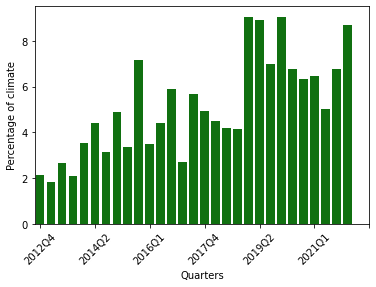

In [10]:
import seaborn as sns
viewQ["Quarters"] = viewQ["date2"]
viewQ["Percentage of climate"] = viewQ["percentage_climate"]
g = sns.barplot(data=viewQ, x="Quarters", y="Percentage of climate", color="green")
plt.xticks([0, 5, 10, 15, 20, 25, 30],rotation=45)
#viewQ.plot()
#view2.plot()
#plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2012'),
  Text(1, 0, '2013'),
  Text(2, 0, '2014'),
  Text(3, 0, '2015'),
  Text(4, 0, '2016'),
  Text(5, 0, '2017'),
  Text(6, 0, '2018'),
  Text(7, 0, '2019'),
  Text(8, 0, '2020'),
  Text(9, 0, '2021'),
  Text(10, 0, '2022')])

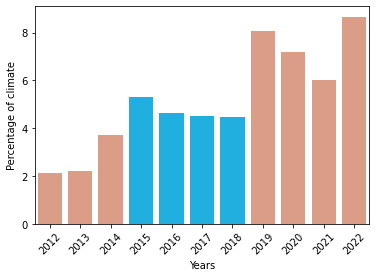

In [11]:
view2["Years"] = view2["date2"]
view2["Percentage of climate"] = view2["percentage_climate"]
g = sns.barplot(data=view2, x="Years", y="Percentage of climate", palette=['darksalmon', 'darksalmon', 'darksalmon', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'darksalmon', 'darksalmon', 'darksalmon'])
view2["Years"] = range(len(view2))
#g = sns.regplot(x="Years", y="Percentage of climate", data=view2, color="mediumseagreen")

plt.xticks(rotation=45)
#plt.savefig('ft-meetings-temporal-prop.pdf')

In [12]:
print(df_selection[(df_selection["text"].str.contains("corona", case=False))&(df_selection["year"]=="2016")]["text"][84894])

KeyError: 84894

In [ ]:
df_selection[(df_selection["text"].str.contains("corona", case=False))|(df_selection["text"].str.contains("covid", case=False))].groupby("year").count()

,speaker,politician,title,party,text,date,y_pred,month,id,climate,non-climate
year,,,,,,,,,,,
2016,1,1,1,1,1,1,1,1,1,1,1
2020,2480,2480,2480,2480,2480,2480,2480,2480,2480,2480,2480
2021,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
2022,91,91,91,91,91,91,91,91,91,91,91


In [ ]:
print(2480/(1767+26598)) ## COVID 2020
print(1849/(1443+25016)) ## COVID 2020
yearly

0.08743169398907104
0.06988170376809404


,climate,non-climate,percentage_climate
date,,,
2012,118,6832,1.697842
2013,325,17932,1.780139
2014,528,16861,3.036402
2015,997,18761,5.046057
2016,1137,26044,4.183069
2017,1105,23157,4.554447
2018,946,19504,4.625917
2019,1432,17484,7.570311
2020,1767,26495,6.252211


##### Party changes

In [13]:
import seaborn as sns
party = df_selection.groupby(["year", "party"]).agg({'climate': 'sum', 'non-climate':'sum'}).reset_index()
party['percentage_climate'] = party.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)
party

,year,party,climate,non-climate,percentage_climate
0,2012,(DF),16,1716,0.923788
1,2012,(EL),35,1089,3.113879
2,2012,(KF),10,794,1.243781
3,2012,(LA),29,889,3.159041
4,2012,(RV),53,807,6.162791
...,...,...,...,...,...
91,2022,(LA),1,89,1.111111
92,2022,(RV),14,323,4.154303
93,2022,(S),135,1418,8.692853
94,2022,(SF),53,429,10.995851


In [14]:
party_all = df_selection.groupby(["party"]).agg({'climate': 'sum', 'non-climate':'sum'}).reset_index()
party_all['percentage_climate'] = party_all.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)
top_party = party_all.sort_values(by="percentage_climate",ascending=False)["party"].unique()
wing = ["(S)", "(S)", "(S)", "(S)", "(S)", "(V)", "(V)", "(V)", "(V)"]
avg = party_all.sort_values(by="percentage_climate",ascending=False).reset_index()
avg

,index,party,climate,non-climate,percentage_climate
0,0,(ALT),1636,10800,13.155355
1,5,(RV),1497,20233,6.889093
2,7,(SF),1714,25376,6.327058
3,2,(EL),2456,39152,5.902711
4,6,(S),3440,65860,4.963925
5,8,(V),2859,55907,4.865058
6,3,(KF),845,19296,4.195422
7,4,(LA),876,21159,3.975494
8,1,(DF),1034,44345,2.278587


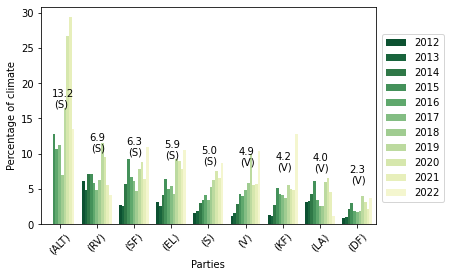

In [15]:
party["Years"] = party["year"]
party["Percentage of climate"] = party["percentage_climate"]
party["Parties"] = party["party"]
avg["Average"] = avg["percentage_climate"]

g = sns.barplot(data=party, x="Parties", y="Percentage of climate", hue="Years", order=top_party, palette="YlGn_r")
plt.legend(bbox_to_anchor=(1.02, 0.875), loc='upper left', borderaxespad=0)
avg["order"] = range(len(avg))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-.2, point['y']+5.005, str(round(point['val'],1)))
        ax.text(point['x']-.15, point['y']+3.505, str(wing[i]))

label_point(avg["order"], avg["Average"], avg.Average, plt.gca()) 
plt.xticks(rotation=45)
plt.savefig('ft-meetings-temporal-prop-parties.pdf', bbox_inches="tight")

##### Latest 2019 -->

In [140]:
party = df_selection[df_selection["year"].astype("int")>=2022].groupby(["year", "party"]).agg({'climate': 'sum', 'non-climate':'sum'}).reset_index()
party['percentage_climate'] = party.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)
party = party[party["party"]!="(ALT)"]
party = party[party["party"]!="(LA)"]

party_all = df_selection[df_selection["year"].astype("int")>=2022].groupby(["party"]).agg({'climate': 'sum', 'non-climate':'sum'}).reset_index()
party_all['percentage_climate'] = party_all.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)
top_party = party_all.sort_values(by="percentage_climate",ascending=False)["party"].unique()
top_party = top_party[:-2]
wing = ["(S)", "(S)", "(S)", "(S)", "(V)", "(S)", "(V)", "(V)", "(V)"]
avg = party_all.sort_values(by="percentage_climate",ascending=False).reset_index()
avg 

,index,party,climate,non-climate,percentage_climate
0,7,(SF),35,297,10.542169
1,8,(V),49,472,9.404990
2,3,(KF),22,230,8.730159
3,2,(EL),27,288,8.571429
4,6,(S),68,868,7.264957
5,1,(DF),17,355,4.569892
6,5,(RV),9,244,3.557312
7,0,(ALT),1,34,2.857143
8,4,(LA),1,57,1.724138


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '(SF)'),
  Text(1, 0, '(V)'),
  Text(2, 0, '(KF)'),
  Text(3, 0, '(EL)'),
  Text(4, 0, '(S)'),
  Text(5, 0, '(DF)'),
  Text(6, 0, '(RV)')])

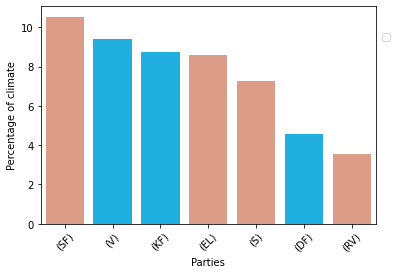

In [141]:
party["Years"] = party["year"]
party["Percentage of climate"] = party["percentage_climate"]
party["Parties"] = party["party"]
avg["Average"] = avg["percentage_climate"]

g = sns.barplot(data=party, x="Parties", y="Percentage of climate", order=top_party, palette=['darksalmon', 'deepskyblue', 'deepskyblue','darksalmon', 'darksalmon', 'deepskyblue','darksalmon'])
plt.legend(bbox_to_anchor=(1.02, 0.875), loc='upper left', borderaxespad=0)
avg["order"] = range(len(avg))
 
plt.xticks(rotation=45)

##### Top politicians

In [32]:
import seaborn as sns
pol = df_selection.groupby(["year", "politician", "party"]).agg({'climate': 'sum', 'non-climate':'sum'}).reset_index()
pol['percentage_climate'] = pol.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)
pol['total_quotes'] = pol["climate"] + pol["non-climate"]
pol

,year,politician,party,climate,non-climate,percentage_climate,total_quotes
0,2012,Alex Ahrendtsen,(DF),0,75,0.000000,75
1,2012,Anders Samuelsen,(LA),1,22,4.347826,23
2,2012,Andreas Steenberg,(RV),0,69,0.000000,69
3,2012,Ane Halsboe-Larsen,(S),0,40,0.000000,40
4,2012,Anne Baastrup,(SF),0,8,0.000000,8
...,...,...,...,...,...,...,...
2130,2022,Trine Torp,(SF),0,19,0.000000,19
2131,2022,Troels Ravn,(S),2,22,8.333333,24
2132,2022,Ulla Tørnæs,(V),0,6,0.000000,6
2133,2022,Victoria Velasquez,(EL),0,10,0.000000,10


In [33]:
pol_all = df_selection.groupby(["politician", "party"]).agg({'climate': 'sum', 'non-climate':'sum'}).reset_index()
pol_all['percentage_climate'] = pol_all.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)
pol_all['total_quotes'] = pol_all["climate"] + pol_all["non-climate"]
print(len(pol_all))
pol_all = pol_all[pol_all["total_quotes"]>=50]
print(len(pol_all))

top_pol = pol_all.sort_values(by="percentage_climate",ascending=False)["politician"].unique()
wing = ["(S)", "(S)", "(S)", "(S)", "(V)", "(S)", "(V)", "(V)", "(V)"]
avg = pol_all.sort_values(by="percentage_climate",ascending=False).reset_index()
top10 = avg.head(10)
top10

396
331


,index,politician,party,climate,non-climate,percentage_climate,total_quotes
0,332,Ruben Kidde,(RV),70,20,77.777778,90
1,340,Signe Munk,(SF),267,106,71.581769,373
2,17,Anne Paulin,(S),150,61,71.090047,211
3,202,Lars Christian Lilleholt,(V),808,569,58.678286,1377
4,264,Mikkel Dencker,(DF),294,365,44.613050,659
5,62,Christian Poll,(ALT),416,681,37.921604,1097
6,71,Dan Jørgensen,(S),480,994,32.564450,1474
7,318,Rasmus Helveg Petersen,(RV),225,478,32.005690,703
8,55,Carsten Kissmeyer,(V),70,154,31.250000,224
9,367,Thomas Danielsen,(V),256,584,30.476190,840


In [34]:
## Select only top 10
pol = pol[pol["politician"].isin(top10["politician"])]
party_aff = ["(RV)", "(SF)", "(S)", "(V)", "(DF)", "(ALT)", "(EL)", "(V)", "(EL)", "(V)"]
pol

,year,politician,party,climate,non-climate,percentage_climate,total_quotes
85,2012,Lars Christian Lilleholt,(V),2,6,25.000000,8
121,2012,Mikkel Dencker,(DF),6,44,12.000000,50
144,2012,Rasmus Helveg Petersen,(RV),2,14,12.500000,16
158,2012,Thomas Danielsen,(V),1,33,2.941176,34
201,2013,Dan Jørgensen,(S),0,7,0.000000,7
...,...,...,...,...,...,...,...
2020,2022,Dan Jørgensen,(S),28,35,44.444444,63
2063,2022,Lars Christian Lilleholt,(V),3,8,27.272727,11
2105,2022,Rasmus Helveg Petersen,(RV),6,7,46.153846,13
2115,2022,Signe Munk,(SF),18,7,72.000000,25


C:\Users\COBOD\AppData\Local\Temp\ipykernel_13728\3628091330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pol["Years"] = pol["year"]
C:\Users\COBOD\AppData\Local\Temp\ipykernel_13728\3628091330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pol["Percentage of climate"] = pol["percentage_climate"]
C:\Users\COBOD\AppData\Local\Temp\ipykernel_13728\3628091330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Ruben Kidde'),
  Text(1, 0, 'Signe Munk'),
  Text(2, 0, 'Anne Paulin'),
  Text(3, 0, 'Lars Christian Lilleholt'),
  Text(4, 0, 'Mikkel Dencker'),
  Text(5, 0, 'Christian Poll'),
  Text(6, 0, 'Dan Jørgensen'),
  Text(7, 0, 'Rasmus Helveg Petersen'),
  Text(8, 0, 'Carsten Kissmeyer'),
  Text(9, 0, 'Thomas Danielsen')])

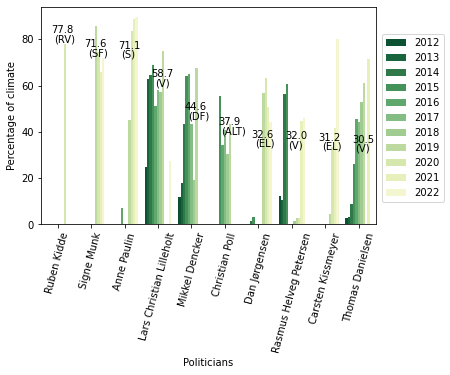

In [35]:

pol["Years"] = pol["year"]
pol["Percentage of climate"] = pol["percentage_climate"]
pol["Politicians"] = pol["politician"]
top10["Average"] = top10["percentage_climate"]

g = sns.barplot(data=pol, x="Politicians", y="Percentage of climate", hue="Years", order=top10["politician"].unique(), palette="YlGn_r")
plt.legend(bbox_to_anchor=(1.02, 0.875), loc='upper left', borderaxespad=0)
top10["order"] = range(len(top10))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-.2, point['y']+5.005, str(round(point['val'],1)))
        ax.text(point['x']-.1, point['y']+1.005, str(party_aff[i]))

label_point(top10["order"], top10["Average"], top10.Average, plt.gca()) 
plt.xticks(rotation=75)